<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">


# Building a groundwater model from scratch

This notebook shows how to build a basic model from scratch using `nlmod`.

In [1]:
# import packages
import flopy as fp
import matplotlib.pyplot as plt
import nlmod
import numpy as np
import pandas as pd

c:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\numexpr\expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
c:\Users\oebbe\anaconda3\envs\nlmod\lib\site-packages\numexpr\expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')


In [2]:
# Show logging messages with level "INFO" or higher
nlmod.util.get_color_logger("INFO");

## Download MODFLOW-binaries
The first time you use nlmod you need to download the MODFLOW-excecutables. We do this with the following code:

In [3]:
if not nlmod.util.check_presence_mfbinaries():
    nlmod.util.download_mfbinaries()

## Model parameters

Set some modelgrid parameters

In [4]:
extent = [-500, 500, -500, 500] #extent of the model [xmin, xmax, ymin, ymax]

top = 0.0 #top level of the first model layers
botm = [-10, -15, -30] #bottom level of every model layer 

kh = [10, 0.1, 20] # horizontal conductivity per model layer
kv = [0.5 * k for k in kh] # vertical conductivity per model layer

dx = 10.0 # cell size in x direction
dy = 10.0 # cell size in y direction

### Create model dataset

Create a model dataset with the coördinates `layer`, `x` and `y`. The model data such as top, botm, kh, kv are stored in the modeldataset with the data linked to the relevant coördinates.

In [5]:
ds = nlmod.get_ds(
    extent,
    delr=dx,
    delc=dy,
    top=top,
    botm=botm,
    kh=kh,
    kv=kv,
    model_ws="./scratch_model",
    model_name="from_scratch",
)
ds

INFO:nlmod.dims.base:resample layer model data to structured modelgrid


<xarray.Dataset>
Dimensions:  (y: 100, x: 100, layer: 3)
Coordinates:
  * layer    (layer) int32 1 2 3
  * x        (x) float64 -495.0 -485.0 -475.0 -465.0 ... 465.0 475.0 485.0 495.0
  * y        (y) float64 495.0 485.0 475.0 465.0 ... -465.0 -475.0 -485.0 -495.0
Data variables:
    top      (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    botm     (layer, y, x) float64 -10.0 -10.0 -10.0 -10.0 ... -30.0 -30.0 -30.0
    kh       (layer, y, x) float64 10.0 10.0 10.0 10.0 ... 20.0 20.0 20.0 20.0
    kv       (layer, y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 10.0 10.0 10.0 10.0
    area     (y, x) float64 100.0 100.0 100.0 100.0 ... 100.0 100.0 100.0 100.0
    idomain  (layer, y, x) int32 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Attributes:
    extent:                    [-500, 500, -500, 500]
    gridtype:                  structured
    delr:                      10.0
    delc:                      10.0
    model_name:                from_scratch
    mfversion:                 mf6
    model_dataset_created_on:  20230608_17:25:16
    exe_name:                  C:\Users\oebbe\02_python\nlmod\nlmod\bin\mf6.exe
    model_ws:                  ./scratch_model
    figdir:                    ./scratch_model\figure
    cachedir:                  ./scratch_model\cache
    transport:                 0

### Set time discretisation

Add the time dimension to the model dataset. In this case we use the default settings to create a steady state model with a single time step.

In [6]:
ds = nlmod.time.set_ds_time(ds, time=pd.Timestamp.today(), steady_state=True)
ds.time

<xarray.DataArray 'time' (time: 1)>
array(['2033-06-07T17:25:16.328062000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2033-06-07T17:25:16.328062
Attributes:
    time_units:    DAYS
    start:         2023-06-08 17:25:16.328062
    nstp:          1
    tsmult:        1.0
    steady_start:  1
    steady_state:  1

### Start building model

Here we build the modflow package using the model dataset.

In [7]:
sim = nlmod.sim.sim(ds)
tdis = nlmod.sim.tdis(ds, sim)
ims = nlmod.sim.ims(sim, complexity="SIMPLE")
gwf = nlmod.gwf.gwf(ds, sim)
dis = nlmod.gwf.dis(ds, gwf)
npf = nlmod.gwf.npf(ds, gwf)
ic = nlmod.gwf.ic(ds, gwf, starting_head=1.0)
oc = nlmod.gwf.oc(ds, gwf, save_head=True)

INFO:nlmod.sim.sim:creating modflow SIM
INFO:nlmod.sim.sim:creating modflow TDIS
INFO:nlmod.sim.sim:creating modflow IMS
INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow DIS
INFO:nlmod.gwf.gwf:creating modflow NPF
INFO:nlmod.gwf.gwf:creating modflow IC
INFO:nlmod.gwf.gwf:creating modflow OC


### Add wells

We add two extraction wells to the model. They have an extraction rate of respectively 100.0 and 300.0 m3/day.

In [8]:
wells = pd.DataFrame(columns=["x", "y", "top", "botm", "Q"], index=range(2))
wells.index.name = "well no."
wells.loc[0] = 100, -50, -5, -10, -100.0
wells.loc[1] = 200, 150, -20, -30, -300.0
wells

,x,y,top,botm,Q
well no.,,,,,
0,100,-50,-5,-10,-100.0
1,200,150,-20,-30,-300.0


In [9]:
# create the well package using the DataFrame
wel = nlmod.gwf.wells.wel_from_df(wells, gwf, save_flows=True, pname='WEL')

Adding WELs: 100%|██████████| 2/2 [00:00<00:00, 167.14it/s]


### Add river

In [10]:
xyriv = [
    (250, -500),
    (300, -300),
    (275, 0),
    (200, 250),
    (175, 500),
]

riv_layer = 0  # add to first layer

bed_resistance = 0.1  # days
riv_cond = dx * dy / bed_resistance  # conductance
riv_stage = 1.0  # m NAP
riv_botm = -3.0  # m NAP

riv_data = nlmod.gwf.surface_water.rivdata_from_xylist(
    gwf, xyriv, riv_layer, riv_stage, riv_cond, riv_botm
)

In [11]:
riv = fp.mf6.ModflowGwfriv(gwf, stress_period_data={0: riv_data}, 
                           save_flows=True, pname='RIV')

### Write and run Simulation

In [12]:
nlmod.sim.write_and_run(sim, ds)

INFO:nlmod.sim.sim:write model dataset to cache
  from dask.compatibility import apply

INFO:nlmod.sim.sim:write modflow files to model workspace
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model from_scratch...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package riv...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 105 based on size of stress_period_data
INFO:nlmod.sim.sim:run model
FloPy is using the following executable to run the model: C:\Users\oebbe\02_python\nlmod\nlmod\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/20

### Load heads

In [13]:
ds['heads'] = nlmod.gwf.get_heads_da(ds)

### Plot heads

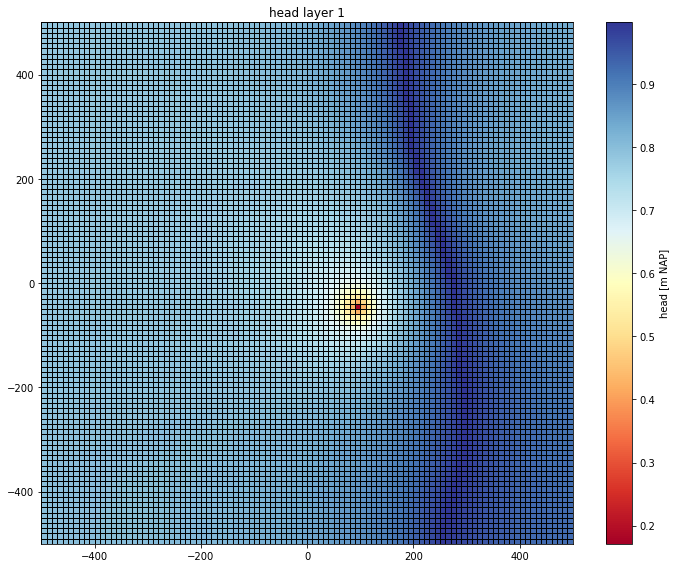

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

pc = nlmod.plot.data_array(
    ds['heads'].sel(layer=1).isel(time=0),
    ds=ds,
    cmap="RdYlBu",
    ax=ax,
    edgecolor="k",
)
ax.axis(extent)
cbar = ax.figure.colorbar(pc, shrink=1.0)
cbar.set_label("head [m NAP]")
ax.set_title("head layer 1")
fig.tight_layout()

## Exercises

#### Exercise 1

In the plot above the heads in model layer 1 are plotted. Make 2 other plots with:
1. The heads in model layer 2 
2. The differences in heads between model layer 1 and 2

Please explain the differences in heads between these layers.

#### Exercise 2

We used the function `nlmod.gwf.get_heads_da` to obtain the modelled heads. Now use the function `nlmod.gwf.get_budget_da` to obatin the flux (budget) of the river package. This data shows how much water infiltrates from the river to the groundwater.
1. Plot the river budget of the first model layer. Explain what you see
2. Calculate the total infiltration from the river to the groundwater.
3. What other fluxes do you expect in this model? How big are they? Can you explain the differences in these fluxes?

#### Exercise 3

Add recharge to the model using the recharge package.